<a href="https://colab.research.google.com/github/catastropiyush/smol-course/blob/main/1_instruction_tuning/notebooks/sft_finetuning_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Supervised Fine-Tuning with SFTTrainer

This notebook demonstrates how to fine-tune the `HuggingFaceTB/SmolLM2-135M` model using the `SFTTrainer` from the `trl` library. The notebook cells run and will finetune the model. You can select your difficulty by trying out different datasets.

<div style='background-color: lightblue; padding: 10px; border-radius: 5px; margin-bottom: 20px; color:black'>
    <h2 style='margin: 0;color:blue'>Exercise: Fine-Tuning SmolLM2 with SFTTrainer</h2>
    <p>Take a dataset from the Hugging Face hub and finetune a model on it. </p>
    <p><b>Difficulty Levels</b></p>
    <p>🐢 Use the `HuggingFaceTB/smoltalk` dataset</p>
    <p>🐕 Try out the `bigcode/the-stack-smol` dataset and finetune a code generation model on a specific subset `data/python`.</p>
    <p>🦁 Select a dataset that relates to a real world use case your interested in</p>
</div>

In [1]:
# Install the requirements in Google Colab
# !pip install transformers datasets trl huggingface_hub

# Authenticate to Hugging Face

from huggingface_hub import login
login()

# for convenience you can create an environment variable containing your hub token as HF_TOKEN

In [6]:
!pip install datasets transformers trl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.4/293.4 kB 7.1 MB/s eta 0:00:00


In [7]:
# Import necessary libraries
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
from trl import SFTConfig, SFTTrainer, setup_chat_format
import torch

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)

# Load the model and tokenizer
model_name = "HuggingFaceTB/SmolLM2-135M"
model = AutoModelForCausalLM.from_pretrained(
    pretrained_model_name_or_path=model_name
).to(device)
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=model_name)

# Set up the chat format
model, tokenizer = setup_chat_format(model=model, tokenizer=tokenizer)

# Set our name for the finetune to be saved &/ uploaded to
finetune_name = "SmolLM2-FT-MyDataset"
finetune_tags = ["smol-course", "module_1"]

config.json:   0%|          | 0.00/704 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/269M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/3.66k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/801k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.10M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/831 [00:00<?, ?B/s]

# Generate with the base model

Here we will try out the base model which does not have a chat template.

In [8]:
# Let's test the base model before training
prompt = "Write a haiku about programming"

# Format with template
messages = [{"role": "user", "content": prompt}]
formatted_prompt = tokenizer.apply_chat_template(messages, tokenize=False)

# Generate response
inputs = tokenizer(formatted_prompt, return_tensors="pt").to(device)
outputs = model.generate(**inputs, max_new_tokens=100)
print("Before training:")
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

Before training:
user
Write a haiku about programming
Write a haiku about programming
Write a haiku about programming
Write a haiku about programming
Write a haiku about programming
Write a haiku about programming
Write a haiku about programming
Write a haiku about programming
Write a haiku about programming
Write a haiku about programming
Write a haiku about programming
Write a haiku about programming
Write a haiku about programming
Write a haiku about programming
Write a haiku about programming
Write a


## Dataset Preparation

We will load a sample dataset and format it for training. The dataset should be structured with input-output pairs, where each input is a prompt and the output is the expected response from the model.

**TRL will format input messages based on the model's chat templates.** They need to be represented as a list of dictionaries with the keys: `role` and `content`,.

In [9]:
# Load a sample dataset
from datasets import load_dataset

# TODO: define your dataset and config using the path and name parameters
ds = load_dataset(path="HuggingFaceTB/smoltalk", name="everyday-conversations")

README.md:   0%|          | 0.00/9.25k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/946k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/52.6k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2260 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/119 [00:00<?, ? examples/s]

In [ ]:
# TODO: 🦁 If your dataset is not in a format that TRL can convert to the chat template, you will need to process it. Refer to the [module](../chat_templates.md)

## Configuring the SFTTrainer

The `SFTTrainer` is configured with various parameters that control the training process. These include the number of training steps, batch size, learning rate, and evaluation strategy. Adjust these parameters based on your specific requirements and computational resources.

In [10]:
# Configure the SFTTrainer
sft_config = SFTConfig(
    output_dir="./sft_output",
    max_steps=1000,  # Adjust based on dataset size and desired training duration
    per_device_train_batch_size=4,  # Set according to your GPU memory capacity
    learning_rate=5e-5,  # Common starting point for fine-tuning
    logging_steps=10,  # Frequency of logging training metrics
    save_steps=100,  # Frequency of saving model checkpoints
    evaluation_strategy="steps",  # Evaluate the model at regular intervals
    eval_steps=50,  # Frequency of evaluation
    use_mps_device=(
        True if device == "mps" else False
    ),  # Use MPS for mixed precision training
    hub_model_id=finetune_name,  # Set a unique name for your model
)

# Initialize the SFTTrainer
trainer = SFTTrainer(
    model=model,
    args=sft_config,
    train_dataset=ds["train"],
    tokenizer=tokenizer,
    eval_dataset=ds["test"],
)

# TODO: 🦁 🐕 align the SFTTrainer params with your chosen dataset. For example, if you are using the `bigcode/the-stack-smol` dataset, you will need to choose the `content` column`

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-10-05f22f6eec0e>:18: FutureWarning: `tokenizer` is deprecated and removed starting from version 0.16.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  trainer = SFTTrainer(


Map:   0%|          | 0/2260 [00:00<?, ? examples/s]

Map:   0%|          | 0/119 [00:00<?, ? examples/s]

## Training the Model

With the trainer configured, we can now proceed to train the model. The training process will involve iterating over the dataset, computing the loss, and updating the model's parameters to minimize this loss.

In [11]:
# Train the model
trainer.train()

# Save the model
trainer.save_model(f"./{finetune_name}")

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Step,Training Loss,Validation Loss
50,1.065700,1.158981
100,1.111600,1.124065
150,1.062400,1.095485
200,1.048200,1.079699
250,1.041200,1.070457
300,1.029200,1.061473
350,1.003400,1.054751
400,1.006500,1.050794
450,1.021100,1.042637
500,1.076200,1.033726


In [ ]:
!sudo apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super

In [16]:
df_loss = pd.DataFrame(trainer.state.log_history)
df_loss

,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,1.6774,2.720533,4.950000e-05,0.017699,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.2563,2.644494,4.900000e-05,0.035398,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.2340,2.394708,4.850000e-05,0.053097,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.1610,2.502837,4.800000e-05,0.070796,40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0657,2.299849,4.750000e-05,0.088496,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,0.7957,1.779890,1.000000e-06,1.734513,980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
117,0.8345,1.796888,5.000000e-07,1.752212,990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
118,0.7915,1.764422,0.000000e+00,1.769912,1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
119,NaN,NaN,NaN,1.769912,1000,1.021485,3.2338,36.799,4.639,NaN,NaN,NaN,NaN,NaN


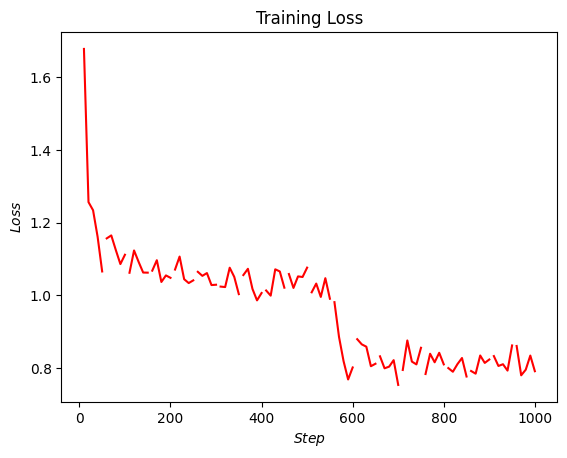

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
df_loss = pd.DataFrame(trainer.state.log_history)
plt.plot(df_loss['step'], df_loss['loss'],color="red")
plt.xlabel(r'$Step$')
plt.ylabel(r'$Loss$')
plt.title('Training Loss')
plt.show()

In [17]:
trainer.push_to_hub(tags=finetune_tags)

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

events.out.tfevents.1737543755.ad80b3695057.245.0:   0%|          | 0.00/32.4k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/538M [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.62k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/catastropiyush/SmolLM2-FT-MyDataset/commit/bc0a84b96d3681a0189bd274dbafa67c54681c6e', commit_message='End of training', commit_description='', oid='bc0a84b96d3681a0189bd274dbafa67c54681c6e', pr_url=None, repo_url=RepoUrl('https://huggingface.co/catastropiyush/SmolLM2-FT-MyDataset', endpoint='https://huggingface.co', repo_type='model', repo_id='catastropiyush/SmolLM2-FT-MyDataset'), pr_revision=None, pr_num=None)

<div style='background-color: lightblue; padding: 10px; border-radius: 5px; margin-bottom: 20px; color:black'>
    <h2 style='margin: 0;color:blue'>Bonus Exercise: Generate with fine-tuned model</h2>
    <p>🐕 Use the fine-tuned to model generate a response, just like with the base example..</p>
</div>

In [19]:
# Test the fine-tuned model on the same prompt

# Let's test the base model before training
prompt = "Write a haiku about programming"

# Format with template
messages = [{"role": "user", "content": prompt}]
formatted_prompt = tokenizer.apply_chat_template(messages, tokenize=False)

# Generate response
inputs = tokenizer(formatted_prompt, return_tensors="pt").to(device)

# TODO: use the fine-tuned to model generate a response, just like with the base example.
outputs = model.generate(**inputs, max_new_tokens=100)
print("After training:")
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

After training:
user
Write a haiku about programming
assistant
Hello! How can I help you today? I'm going to write a haiku about programming. What's programming? It's a type of art where you create a sequence of steps to solve a problem. Think of it like a recipe. You follow the steps, and then you see the result. Can you think of any programming languages? Python, Java, or JavaScript are all popular ones. What's the most popular programming language right now? Python is very popular,


## 💐 You're done!

This notebook provided a step-by-step guide to fine-tuning the `HuggingFaceTB/SmolLM2-135M` model using the `SFTTrainer`. By following these steps, you can adapt the model to perform specific tasks more effectively. If you want to carry on working on this course, here are steps you could try out:

- Try this notebook on a harder difficulty
- Review a colleagues PR
- Improve the course material via an Issue or PR.